In [4]:
# #once per cluster
# s3helper.open_bucket('mas-dse-open',region='us-west-2')

# info_files=s3helper.ls('Weather/Info')
# Without_path=[x[13:] for x in info_files]


# !mkdir /mnt/workspace/WeatherInfo

# for i in range(len(info_files)-1):   # Last entry is the directory name
#     _from=info_files[i]
#     _to='/mnt/workspace/WeatherInfo/'+Without_path[i]
#     print('From %s to %s'%(_from,_to))
#     s3helper.s3_to_local(_from,_to)
    
# s3helper.open_bucket('dse-weather-west-2', region="us-west-2")
# s3helper.ls('')
# s3helper.s3_to_hdfs("weather.parquet", "/tmp/weather.parquet")
# s3helper.s3_to_hdfs("info/stations.parquet", "/tmp/stations.parquet")
# print(s3helper.ls_hdfs("/tmp"))

In [1]:
import os
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T

os.getcwd()
os.chdir("/mnt/workspace/Public-DSC291/notebooks/Section2-PCA/Full_Dataset_analysis")
os.getcwd()

from Startup import *

finished standard imports
dict_items([('spark.executor.memory', '3g'), ('spark.default.parallelism', '10'), ('spark.executor.cores', '1'), ('spark.logConf', 'True'), ('spark.cores.max', '4'), ('spark.app.name', 'Weather_PCA')])
started SparkContext and SQLContext in 12.90 seconds
loaded weather.parquet in 8.15 seconds
loaded stations.parquet in 0.20 seconds
registered dataframes as tables in 0.20 seconds


# Load Data

Here we load the data for the US.  There are a few stations in Canada and Mexico included but shouldn't be a big deal

In [2]:
%%time
query="""
SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state <> '' AND weather.Measurement='PRCP'
"""

print(query)
US_weather_df=sqlContext.sql(query)
sqlContext.registerDataFrameAsTable(US_weather_df,'US_weather_df')


SELECT stations.ID, stations.elevation, stations.state, stations.latitude, stations.longitude,
        weather.Station, weather.Measurement, weather.Year, weather.Values
FROM stations
LEFT JOIN weather
ON stations.ID = weather.Station
WHERE stations.state <> '' AND weather.Measurement='PRCP'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 101 ms


In [3]:
print('US has %d rows before filter'%(US_weather_df.count()))
US_weather_df.columns

US has 959259 rows before filter


['ID',
 'elevation',
 'state',
 'latitude',
 'longitude',
 'Station',
 'Measurement',
 'Year',
 'Values']

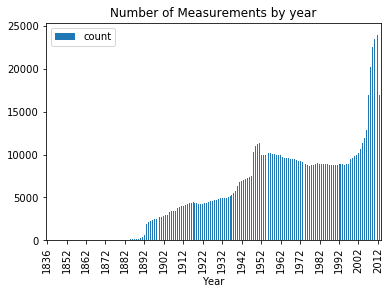

In [4]:
cnt = US_weather_df.groupBy('Year').count()
cnt = cnt.toPandas()
cnt = cnt.sort_values('Year')
ax = cnt.plot.bar('Year', 'count')
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])
ax.xaxis.set_ticklabels(ticklabels[::10])
plt.title('Number of Measurements by year')
plt.show()

In [5]:
filter_year = 1945
#Filter for certain dates
US_weather_df = US_weather_df.filter(US_weather_df.Year > filter_year)
print('US has %d rows after filter'%(US_weather_df.count()))

US has 729715 rows after filter


In [6]:
#Filter for only stations with data in the full range
#May or may not be necessary
cnt_bystation = US_weather_df.groupBy('Station').count()
US_weather_df = US_weather_df.join(cnt_bystation, "Station")

In [7]:
mx = cnt_bystation.agg({"count": "max"}).collect()[0]["max(count)"]

In [8]:
US_weather_df = US_weather_df.filter(US_weather_df['count'] == mx)
print('US has %d rows after filter'%(US_weather_df.count()))

US has 118796 rows after filter


In [9]:
US_weather_df.groupby('Year').count().show()

+----+-----+
|Year|count|
+----+-----+
|1959| 1747|
|1990| 1747|
|1975| 1747|
|1977| 1747|
|2003| 1747|
|2007| 1747|
|1974| 1747|
|1955| 1747|
|2006| 1747|
|1978| 1747|
|1961| 1747|
|2013| 1747|
|1952| 1747|
|1956| 1747|
|1988| 1747|
|1997| 1747|
|1994| 1747|
|1968| 1747|
|1951| 1747|
|1973| 1747|
+----+-----+
only showing top 20 rows



# Change from Jan-Jan to Jun-Jun

PRCP data has 365 x 2 = 730 measurements per year so the start of June is at 151 x 2 = 302

In [10]:
def f1(row):
    return row['Values'][:362]

def f2(row):
    return row['Values'][362:]

def Jan2Jun(df):
    df_first = df.copy()
    
    # df_first is same as df except for its ['Values'] column only contains the 
    # the first half year data.
    df_first['V_first'] = df_first.apply(f1, axis=1)
    
    # subtract df_first 'Year' column by 1, because we want to join originally 1998 Jan-Jun to 1997 July-Dec,
    # as 1997 data, so minus 1998 by 1 to match 1997.
    df_first['Year'] = df_first.apply(lambda x: x['Year']-1, axis=1)
    
    # df_second is same as df except for its ['Values'] column only contains the 
    # the second half year data.
    df_second = df.copy()
    df_second['V_second'] = df_second.apply(f2, axis=1)
    
    # drop the inrrelevant columns of df_second so that join can be easier later. I only kept 'ID' and 'Year'
    # that are used to be joined on later.
    df_second = df_second.drop(['elevation', 'state', 'Station',
                                'Measurement', 'Values', 'latitude',
                                'longitude', 'count'], axis=1)
    
    # join df_first and df_second on ID, Year.
    result = pd.merge(df_first, df_second, on=['ID', 'Year'], how='inner')
    
    # generate the thansformed data, e.g. 1997 July - 1998 June from 'V_second' (1997 July - 1997 Dec) and 
    # 'V_first' (1998 Jan - 1998 June)
    result['Values'] = result.apply(lambda x: x['V_second'] + x['V_first'], axis=1)
    
    # drop V_second and V_first as they are useless now.
    return result.drop(['V_second', 'V_first'], axis=1)

US_weather_pdf = US_weather_df.toPandas()
US_weather_pdf = Jan2Jun(US_weather_pdf)

In [13]:
US_weather_pdf.head()

,Station,ID,elevation,state,latitude,longitude,Measurement,Year,Values,count
0,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1946,"[0, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12...",68
1,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1947,"[32, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, ...",68
2,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1948,"[0, 0, 0, 0, 0, 0, 0, 0, 96, 85, 0, 0, 176, 92...",68
3,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1949,"[0, 0, 0, 0, 128, 75, 32, 88, 104, 89, 0, 0, 9...",68
4,USC00033466,USC00033466,190.8,AR,34.5128,-93.0486,PRCP,1950,"[0, 0, 0, 0, 0, 0, 32, 87, 0, 0, 0, 0, 0, 0, 0...",68


In [12]:
US_weather_df = sqlContext.createDataFrame(US_weather_pdf)

# Do calculations

Here we calculate the anomaly per station per year.  Anom_mean refers to the anomaly over the average rainfall for a given year while Anom_sum refers to the anomaly of the total rainfal. 

In [14]:
def get_sum(row):
    row = unpackArray(row,np.float16)
    row[~np.isfinite(row)] = 0
    row = float(np.nansum(row))
    if ~np.isfinite(row): return 0
    return row

def get_mean(row):
    row = unpackArray(row,np.float16)
    row[~np.isfinite(row)] = 0
    row = float(np.nanmean(row))
    if ~np.isfinite(row): return 0
    return row

my_sum = F.UserDefinedFunction(get_sum, T.DoubleType())
my_mean = F.UserDefinedFunction(get_mean, T.DoubleType())

US_weather_df = US_weather_df.withColumn('Values_sum', my_sum('Values'))
US_weather_df = US_weather_df.withColumn('Values_mean', my_mean('Values'))

US_weather_df = US_weather_df.filter(US_weather_df.Values_sum != 0)
US_weather_df = US_weather_df.filter(US_weather_df.Values_mean != 0)

In [15]:
avg_sum = US_weather_df.groupby('Station').agg({'Values_sum': 'mean'})
avg_mean = US_weather_df.groupby('Station').agg({'Values_mean': 'mean'})
avg = avg_sum.join(avg_mean, "Station")

In [16]:
a = US_weather_df.alias('a')
b = avg.alias('b')
US_weather_df = a.join(b, "Station")

In [17]:
US_weather_df = US_weather_df.drop('Values', 'ID')

In [18]:
US_weather_df = US_weather_df.withColumn('Anom_sum', F.col('Values_sum')-F.col('avg(Values_sum)'))
US_weather_df = US_weather_df.withColumn('Anom_mean', F.col('Values_mean')-F.col('avg(Values_mean)'))

# Anomaly by Station

In [35]:
# data gives Anom_mean and Anom_sum per station per year.  Lat/Long given
US_weather_df = US_weather_df.drop('avg(Values_sum)', 'avg(Values_mean)',
                                    'count', 'Measurement', 'Values_sum',
                                    'Values_mean')

In [36]:
US_weather_df.show()

+-----------+---------+-----+--------+---------+----+-------------------+-------------------+
|    Station|elevation|state|latitude|longitude|Year|           Anom_sum|          Anom_mean|
+-----------+---------+-----+--------+---------+----+-------------------+-------------------+
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1946| -1928.119402985074| -5.278218283582092|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1947| -1024.119402985074| -2.809468283582092|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1948|  1039.880597014926|  2.846781716417908|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1949|  2759.880597014926|  7.565531716417908|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1950|   711.880597014926| 1.9405317164179081|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1951|   687.880597014926| 1.8780317164179081|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1952|  2407.880597014926|  6.596781716417908|
|USC00033466|    190.8|   AR| 34.5128| -93.0486|1953| -2768.

# Calculate average anomaly per state

In [21]:
State_avg = US_weather_df.groupby('state', 'Year').agg({'Anom_mean': 'mean', 'Anom_sum': 'mean'})

In [22]:
%%time
State_avg.show()

+-----+----+-------------------+-------------------+
|state|Year|      avg(Anom_sum)|     avg(Anom_mean)|
+-----+----+-------------------+-------------------+
|   MO|1975|-1443.4743283582095|  -3.95372658800723|
|   SD|1971|  760.4416553595657| 2.0835574601689713|
|   SD|2008|  428.2598371777476| 1.1734012101689704|
|   ID|2003| -670.2912397261343|-1.8370291634446607|
|   TX|1974| 2162.2354626865676|  5.923578351142018|
|   TX|1999|-1207.8746311731388| -3.309290835432102|
|   VA|1976| -1240.877931769723|-3.3995785581023457|
|   WA|1951|-1493.8361779618656|-4.0928332158919805|
|   WA|1972|-1396.0730200671287|-3.8232505678656663|
|   ME|1999| 1420.3482587064677| 3.8953863495024876|
|   IN|1964| -1770.859701492537| -4.853591174984453|
|   CO|1980| -724.5688573449769|-1.9846790206086855|
|   MD|1988|  668.1572139303483| 1.8317552860696522|
|   KY|1996| 3257.9656716417912|  8.924821085004663|
|   QC|2008|-238.25373134328402|-0.6476212686567155|
|   NT|1974|  27.19402985074612|0.073460820895

In [23]:
pdf = State_avg.filter((F.col("state") == "CA")).toPandas()

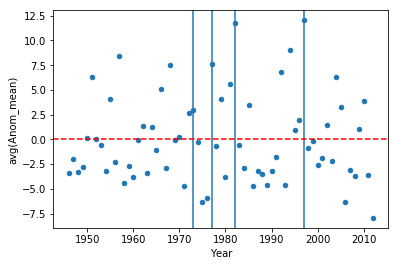

In [39]:
major_elnino = [1973, 1977, 1982, 1997]
pdf.plot.scatter('Year', 'avg(Anom_mean)')
for x in major_elnino: plt.axvline(x)
plt.axhline(0, linestyle = '--', color = 'r')
plt.show()

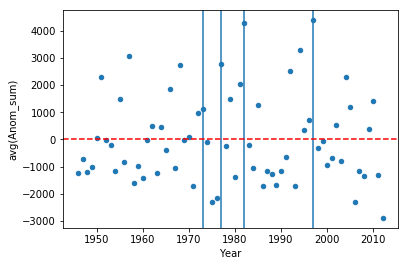

In [40]:
major_elnino = [1973, 1977, 1982, 1997]
pdf.plot.scatter('Year', 'avg(Anom_sum)')
for x in major_elnino: plt.axvline(x)
plt.axhline(0, linestyle = '--', color = 'r')
plt.show()